<img src='data/images/section-notebook-header.png' />

# Machine Translation with RNN Encoder-Decoder

Recurrent Neural Networks (RNNs) have been widely used in machine translation tasks, particularly for sequence-to-sequence modeling. Here's how RNNs can be applied to machine translation:

* **Encoder-Decoder Architecture:** RNNs are often used in a specific architecture called the encoder-decoder model. The encoder takes the source language sentence as input and processes it sequentially, word by word, capturing the contextual information and representing it as a fixed-length vector, often referred to as the "context" or "thought" vector. The encoder typically consists of recurrent layers, such as LSTM or GRU, which maintain a hidden state that carries information from previous words to the next.

* **Attention Mechanism:** In machine translation, long sentences or phrases can be challenging to translate accurately, as the entire sentence needs to be encoded into a fixed-length vector. To address this, attention mechanisms were introduced. Attention allows the decoder to focus on different parts of the source sentence while generating the translation. It dynamically determines which words in the source sentence are most relevant at each decoding step.

* **Decoding and Generation:** Once the encoder has processed the source sentence and produced the context vector, the decoder RNN takes over. It generates the translated sentence word by word, conditioned on the context vector and the previously generated words. At each decoding step, the decoder RNN takes the context vector, the previously generated word, and the hidden state as input, and predicts the probability distribution over the target vocabulary. The word with the highest probability is selected as the output, and the process continues until an end-of-sentence token is generated.

* **Training and Optimization:** RNNs in machine translation are trained using parallel corpora, which consist of pairs of source and target language sentences. During training, the model is optimized to minimize the difference between the predicted translation and the target translation. This is typically done using maximum likelihood estimation or variants of it, such as teacher forcing. Optimization techniques like backpropagation through time (BPTT) are used to update the parameters of the encoder and decoder RNNs.

* **Beam Search:** During inference, when generating translations for unseen sentences, beam search is often employed. Instead of greedily selecting the word with the highest probability at each decoding step, beam search explores multiple hypotheses simultaneously. It maintains a beam of the most likely partial translations and expands them based on the predicted probabilities. This allows the model to consider a wider range of possibilities and generate more accurate translations.

RNN-based machine translation models have demonstrated impressive performance and have been the dominant approach for a long time. However, they can still face challenges in capturing long-range dependencies and dealing with out-of-vocabulary words. More recent approaches, such as transformer-based models, have shown significant improvements in machine translation tasks. Nonetheless, RNNs remain foundational in understanding the evolution of machine translation models.

The image below, taken from the lecture slides, shows encoder-decoder architecture proposed by [Sutskever et al. in 2014](https://proceedings.neurips.cc/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf). In this architecture, both the encoder and decoder are RNNs, with the last hidden state of the encoder serving as the initial hidden state of the decoder.

<img src='data/images/rnn-encoder-decoder-mt.png' />

In this notebook, we will build and train a simple machine learning model from scratch, based on this RNN encoder-decoder architecture. The implementation presented will also include the concept of **attention**. Attention is a mechanism used in recurrent neural networks (RNNs) and other sequence-to-sequence models to focus on relevant parts of the input sequence when generating an output. It allows the model to selectively attend to different parts of the input sequence based on their importance or relevance to the current step of the decoding process.

In traditional RNN models, such as the vanilla RNN or LSTM, the hidden state at each time step summarizes all the information from the previous steps. However, this fixed-length representation can be limiting, especially when processing long sequences or when certain parts of the input sequence are more important than others. Attention mechanisms address this limitation by dynamically computing a weighted sum of the input sequence, emphasizing certain parts that are more relevant to the current decoding step. It enables the model to attend to different parts of the input sequence with different weights, allowing it to focus on the most relevant information.

In an RNN-based encoder-decoder architecture, the attention mechanism computes relevance scores by measuring the similarity between the current hidden state of the decoder and each hidden state of the encoder. There are various ways to calculate these scores, such as dot product, cosine similarity, or using a learned compatibility function. The scores are usually transformed into attention weights through a softmax function to ensure they sum up to 1. Finally, the attention weights are used to compute a weighted sum of the hidden states of the encoder, resulting in a context vector. This context vector is then combined with the current decoding step's hidden state to generate the output or update the hidden state for the next step. The images below, taken from the lecture slides, visualize the computations involved in the attention mechanisms

<img src='data/images/rnn-encoder-decoder-attention-01.png' width='80%' />
<img src='data/images/rnn-encoder-decoder-attention-02.png' width='80%' />
<img src='data/images/rnn-encoder-decoder-attention-03.png' width='80%' />
<img src='data/images/rnn-encoder-decoder-attention-04.png' width='80%' />

By incorporating attention mechanisms, RNN models can selectively attend to different parts of the input sequence, giving them the ability to effectively process long sequences, focus on important information, and improve the quality of their predictions or translations. The implementation of our machine translation model will be flexible enough to specify if attention should be used or not.

## Setting up the Notebook

### Import Required Packages

In [1]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split

We utilize some utility methods from PyTorch, so we need to import the `torch` package.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/NLP/

/content/drive/MyDrive/NLP


In [5]:
from src.rnn import Encoder, Decoder, RnnAttentionSeq2Seq
from src.sampler import BaseDataset, EqualLengthsBatchSampler
from src.utils import Dict2Class, get_line_count, plot_attention_weights

### Checking/Setting the Computation Device

PyTorch allows to train neural networks on supported GPUs to significantly speed up the training process. If you have a support GPU, feel free to utilize it.

In [6]:
use_cuda = torch.cuda.is_available()

# Use this line below to enforce the use of the CPU
#use_cuda = False

device = torch.device("cuda:0" if use_cuda else "cpu")

print("Available device: {}".format(device))

Available device: cuda:0


---

## Building & Testing the Model using a Toy Dataset

The implementation of our machine translation model includes 3 classes -- all can be found in the file `src/rnn.py`

* The `Encoder` class implements the RNN-based encoder that takes the sentence of the source language and encodes this sentence using the recurrent layer.

* The `Decoder` class implement the RNN-based decoder that takes the last hidden state of the decoder -- and optionally all hidden states of the encoder in the case attentions is used -- the learn and generate the output sentences of the target language

* The `RnnAttentionSeq2Seq` class simply wraps the encoder and decoder into a single class for easier use.

Take some time to look and comprehend the code. Similar to previous implementations of the model, the code looks a bit verbose since both the encoder and decoder are quite configurable (see below). Appreciate that the encoder looks like the model for the RNN sentiment classifier and the decoder looks like the model for the RNN language model.

### Create Toy dataset

Before we train our model on the Tatoeba dataset we have prepared in the previous notebook, let's use some simple toy dataset to go through the steps of the encoder and decoder and the combined model. In the sample below, we manually create a batch of 3 pairs of input and target sentences. The indices have no association to any words/tokens as we don't really want to train anything here. Note that all input sequences have a length of 4 and all output sequences have a length 5. Later, when using the real data, we again have to address the challenge of working with sequences of variable lengths.

In [7]:
X_sample = torch.tensor([[4, 5, 6, 7], [4, 5, 6, 7], [4, 5, 6, 7]]).to(device)
Y_sample = torch.tensor([[5, 6, 7, 8, 9], [5, 6, 7, 8, 9], [5, 6, 7, 8, 9]]).to(device)

### Create Model

#### Specify Configuration

As previously mentioned, our model is implemented in a way to make it quite configurable. In principle, we could define the parameters for the encoder and decoder independently, but here we go with a single set of parameter values and name the parameters appropriately so it is clear if the parameter is relevant for the encoder or decoder. For the toy dataset, we just pick some simple values.

In [8]:
params = {
    "device": device,                   # as the decoder also generates sentence it mus be able to move the data to the correct device
    "vocab_size_encoder": 20,           # the size of the source vocabulary determines the input size of the encoder embedding
    "vocab_size_decoder": 20,           # the size of the target vocabulary determines the input size of the decoder embedding
    "embed_size": 50,                   # size of the word embeddings (here the same for encoder and decoder; but not mandatory)
    "rnn_cell": "GRU",                  # in practice GRU or LSTM will always outperform RNN
    "rnn_hidden_size": 128,             # size of the hidden state
    "rnn_num_layers": 2,                # 1 or 2 layers are most common; more rarely sees any benefit
    "rnn_dropout": 0.2,                 # only relevant if rnn_num_layers > 1
    "rnn_encoder_bidirectional": True,  # The encoder can be bidirectional; the decoder can not
    "linear_hidden_sizes": [1024],      # list of sizes of subsequent hidden layers; can be [] (empty); only relevant for the decoder
    "linear_dropout": 0.2,              # if hidden linear layers are used, we can also include Dropout; only relevant for the decoder
    "attention": "DOT",                 # Specify if attention should be used; only "DOT" supported; None if no attention
    "teacher_forcing_prob": 0.5,        # Probability of using Teacher Forcing during training by the decoder
    "special_token_unk": 1,             # Index of special token <UNK>
    "special_token_sos": 2,             # Index of special token <SOS>
    "special_token_eos": 3,             # Index of special token <EOS>
    "clip": 0.5                         # Clipping value to limit gradients to prevent exploding gradients
}

params = Dict2Class(params)

In the list above there might be 2 parameters that haven't been covered in the lectures and you therefore might not be familiar with:

* **Teacher Forcing:** Teacher Forcing is a technique commonly used when training RNN-based decoders in sequence-to-sequence models. It involves feeding the model with the ground truth (true) output sequence during training instead of using its own predictions from the previous time step. By using Teacher Forcing, the model is exposed to the ground truth output sequence during training, which helps in stabilizing the learning process and accelerating convergence. It provides more accurate and reliable gradients for updating the model's parameters.

* **Gradient Clipping:** Gradient clipping is a technique used to mitigate the issue of exploding gradients during training. It involves rescaling the gradients when their norm exceeds a predefined threshold. The purpose of gradient clipping is to ensure more stable and reliable training by preventing large gradient values that can lead to unstable optimization or training difficulties. By applying gradient clipping, the overall effect is that the magnitude of the gradients is kept under control, preventing them from becoming too large. This helps stabilize the optimization process, enabling more reliable and efficient training of deep learning models. It allows the model to make more consistent and meaningful updates to its parameters, leading to better convergence and improved performance.

Both Teacher Forcing and Gradient Clipping are not fundamentally required for training an RNN-based machine translation model, so a more detailed discussion is beyond our scope. However, in practice, those techniques -- and many other tricks and tweaks -- are used to achieve a more effective training and better results. So at least these two common techniques are implemented here.

#### Encoder

Let's create an encoder instance with the parameters defined above.

In [9]:
encoder = Encoder(params).to(device)

print(encoder)

Encoder(
  (embedding): Embedding(20, 50)
  (rnn): GRU(50, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
)


We can now give the encoder the input sequences of our toy batch and check how the output looks like.

In [10]:
encoder_outputs, encoder_hidden = encoder(X_sample)

print('Shape of encoder_outputs:', encoder_outputs.shape)
print('Shape of encoder_hidden:', encoder_hidden.shape)

Shape of encoder_outputs: torch.Size([3, 4, 256])
Shape of encoder_hidden: torch.Size([2, 3, 256])


The shapes of both outputs can be described as follows:

* The shape of `encoder_outputs` is `(batch_size=3, seq_len=4, rnn_hidden_size=256)` representing the 3 sequences in the batch, with each sequences being of length 4, and each item in the sequences represented by a 256-dim vector. Recall that defining the encoder and decoder with 2 layers -- `rnn_num_layers=2`; `encoder_outputs` contains only the outputs after the last layer.

* The shape of `encoder_hidden` is `(num_layers=2, batch_size=3, rnn_hidden_size=256)` representing the 2 recurrent layers, the 3 sequences in the batch, and each item in the sequences represented by a 256-dim vector.

`encoder_hidden` will later be used to initialize the hidden state of the decoder; `encoder_outputs` will be required for the attention mechanism.

#### Decoder

Now let's also create a decoder instance. Note that we also have to specify the criterion (i.e., the loss function) as the calculation of the loss has been moved into the implementation of the decoder. This makes its use when training the model much more convenient. In fact, the loss is the only output of the model.

In [11]:
criterion = nn.CrossEntropyLoss()

decoder = Decoder(params, criterion).to(device)

print(decoder)

Decoder(
  (criterion): CrossEntropyLoss()
  (embedding): Embedding(20, 50)
  (rnn): GRU(50, 256, num_layers=2, batch_first=True, dropout=0.2)
  (attention): DotAttention()
  (linears): ModuleList(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=1024, bias=True)
    (2): ReLU()
  )
  (out): Linear(in_features=1024, out_features=20, bias=True)
)


When training the decoder, it gets as input the batch of target sequences, the last hidden state of the decoder (to initialize the hidden state of the decoder), as well as all hidden states of the decoder for the attention mechanism. The output is the loss based on comparing the predicted target sequence and the true target sequence.

In [12]:
loss = decoder(Y_sample, encoder_hidden, encoder_outputs)

print(loss)

tensor(14.8150, device='cuda:0', grad_fn=<AddBackward0>)


#### Training Encoder & Decoder Separately

By combining the code snippets above, we can now easily write a loop to train our encoder-decoder architecture on the toy dataset.

In [13]:
# Define optimizers for encoder and decoder
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.0005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.0005)

for _ in range(20):
    # Push input sequences through encoder
    encoder_outputs, encoder_hidden = encoder(X_sample)
    # Set initial hidden stated of decoder as the last hidden state of the encoder
    decoder_hidden = encoder_hidden
    # Push target sequences and encoder output through the decoder to get the final loss for that batch
    loss = decoder(Y_sample, decoder_hidden, encoder_outputs)
    # Perform PyTorch magic!
    loss.backward()
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 0.5)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 0.5)
    encoder_optimizer.step()
    decoder_optimizer.step()
    # Print the loss
    print(loss.item() / len(X_sample))

4.935342152913411
4.699870745340983
4.488157272338867
4.271211306254069
4.0131940841674805
3.770805994669596
3.510411262512207
3.215937932332357
3.026238123575846
2.708465576171875
2.4840776125590005
2.317056655883789
2.1740975379943848
1.9639021555582683
1.8713671366373699
1.7131829261779785
1.6290432612101238
1.3611555099487305
1.232780933380127
1.122615893681844


You should see the loss going down after each iteration.

#### Training the Combined Model

Since we always train the encoder and decoder together, we can wrap the `Encoder` and `Decoder` class into a single class, here called `RnnAttentionSeq2Seq`. Again this is not mandatory but a good practice as it makes its later training and use more convenient.

In [14]:
# Create model
model = RnnAttentionSeq2Seq(params, nn.CrossEntropyLoss()).to(device)
# Define optimizers for encoder and decoder
encoder_optimizer = optim.Adam(model.encoder.parameters(), lr=0.0005)
decoder_optimizer = optim.Adam(model.decoder.parameters(), lr=0.0005)
# Print model
print(model)

RnnAttentionSeq2Seq(
  (criterion): CrossEntropyLoss()
  (encoder): Encoder(
    (embedding): Embedding(20, 50)
    (rnn): GRU(50, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (criterion): CrossEntropyLoss()
    (embedding): Embedding(20, 50)
    (rnn): GRU(50, 256, num_layers=2, batch_first=True, dropout=0.2)
    (attention): DotAttention()
    (linears): ModuleList(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=512, out_features=1024, bias=True)
      (2): ReLU()
    )
    (out): Linear(in_features=1024, out_features=20, bias=True)
  )
)


Let's also write an auxiliary method to train a single batch. Again, this just keeps our code cleaner and easier to maintain.

In [15]:
def train_batch(model, encoder_optimizer, decoder_optimizer, X, Y):
    batch_size, num_steps = X.shape

    loss = model(X, Y)

    # Backpropagation
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.encoder.parameters(), model.encoder.params.clip)
    torch.nn.utils.clip_grad_norm_(model.decoder.parameters(), model.decoder.params.clip)
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / (num_steps)

Let's train our model again for 20 epochs by calling the method `train_batch()` in each iteration. Of course, our toy dataset has only a single batch, see we always call the method with the same input and target sequences.

In [16]:
for _ in range(20):
    loss = train_batch(model, encoder_optimizer, decoder_optimizer, X_sample, Y_sample)
    print(loss)

3.728881359100342
3.553464889526367
3.395787477493286
3.2425849437713623
3.0581634044647217
2.87449312210083
2.697709798812866
2.4802350997924805
2.317875862121582
2.1051077842712402
1.9210326671600342
1.7890175580978394
1.6143304109573364
1.4805809259414673
1.3588671684265137
1.2505362033843994
1.166822075843811
1.0204436779022217
0.8931770920753479
0.8209810853004456


### Auxiliary Method with Proper Batch Handling

With the toy dataset, we didn't really care about the sequence values. However, if we want to properly train a model, we have to properly prepare each batch before calling the method `train_batch()`. This mainly means that we need to append the `<EOS>` token to each of the input and target sequences. We perform these steps in the method `train()` below that performs the complete training of our model. As you have seen in previous notebooks, this method essentially iterates over all batches and calls `train_batch` for each batch. The outer loop reflects how many epochs we want to train the model.

In [17]:
def train(model, loader, encoder_optimizer, decoder_optimizer, num_epochs, verbose=False):
    # Set model to "train" mode
    model.train()

    print("Total Training Time (total number of epochs: {})".format(num_epochs))
    for epoch in range(1, num_epochs+1):

        # Initialize epoch loss (cummulative loss fo all batchs)
        epoch_loss = 0.0

        with tqdm(total=len(loader)) as progress_bar:

            for X_batch, Y_batch in loader:
                batch_size, seq_len = X_batch.shape[0], X_batch.shape[1]

                # Add EOS token to all sequences in that batch
                eos = torch.LongTensor([model.encoder.params.special_token_eos]*batch_size)
                X_batch = torch.cat((X_batch, eos.reshape(-1, 1)), axis=1)
                Y_batch = torch.cat((Y_batch, eos.reshape(-1, 1)), axis=1)

                # Move the batch to the correct device
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

                # Train batch and get batch loss
                batch_loss = train_batch(model, encoder_optimizer, decoder_optimizer, X_batch, Y_batch)

                # Update epoch loss given als batch loss
                epoch_loss += batch_loss

                # Update progress bar
                progress_bar.update(batch_size)

        if verbose is True:
            print("Loss:\t{:.3f} (epoch {})".format(epoch_loss, epoch))

### Create `Dataset`, `Sampler` & `DataLoader`

We already know that we can only give batches to an RNN that have sequences of the same lengths. Here, having 2 RNNs -- the encoder and the decoder -- we now additionally have to ensure that all sequence pairs in a batch have the same lengths. For example, for our toy batch all input sequences `X_sample` have the length 4 and all target sequences have `Y_sample` the lengths 5. This is a valid input for our encoder-decoder network.

Of course, real-world sentences can have very different lengths and we need to address this. While concepts such as padding are a common alternative, here we again follow the approach of organizing our batches in a smart way so that the length requirements are always met -- that is, only sentence pairs with the same lengths are put into the same batch. The custom class `EqualLengthsBatchSampler` we already used earlier can also handle pairs of sequences.

The code cell below shows the main steps to create a `DataLoader` you should already be familiar with. Once we iterate over the data loader, we will only get batches where all sample pairs have matching sequence lengths. Of course, this might mean that some batches won't be full in the case there are less than `batch_size` sentence pairs with matching sequence length. But this is less and less likely to occur for an increasing amount of training data.

In [18]:
X_sample = torch.tensor([[4, 5, 6, 7], [4, 5, 6, 7], [4, 5, 6, 7]])
Y_sample = torch.tensor([[5, 6, 7, 8, 9], [5, 6, 7, 8, 9], [5, 6, 7, 8, 9]])

batch_size = 32
dataset_sample = BaseDataset(X_sample, Y_sample)
sampler_sample = EqualLengthsBatchSampler(batch_size, X_sample, Y_sample)
loader_sample = DataLoader(dataset_sample, batch_sampler=sampler_sample, shuffle=False, drop_last=False)

### Complete Training Example

Now we have everything in place to properly train our RNN-based encoder-decoder network.

In [19]:
# Create model
model = RnnAttentionSeq2Seq(params, nn.CrossEntropyLoss()).to(device)
# Define optimizers for encoder and decoder
encoder_optimizer = optim.Adam(model.encoder.parameters(), lr=0.0005)
decoder_optimizer = optim.Adam(model.decoder.parameters(), lr=0.0005)

Well, let's train our model again for 20 epochs over the toy dataset. The resulting losses should roughly match the ones from above.

In [20]:
num_epochs = 20

train(model, loader_sample, encoder_optimizer, decoder_optimizer, num_epochs, verbose=True)

Total Training Time (total number of epochs: 20)


100%|██████████| 3/3 [00:00<00:00, 110.23it/s]


Loss:	3.592 (epoch 1)


100%|██████████| 3/3 [00:00<00:00, 180.25it/s]


Loss:	3.444 (epoch 2)


100%|██████████| 3/3 [00:00<00:00, 166.45it/s]


Loss:	3.300 (epoch 3)


100%|██████████| 3/3 [00:00<00:00, 173.03it/s]


Loss:	3.149 (epoch 4)


100%|██████████| 3/3 [00:00<00:00, 169.18it/s]


Loss:	3.006 (epoch 5)


100%|██████████| 3/3 [00:00<00:00, 167.32it/s]


Loss:	2.842 (epoch 6)


100%|██████████| 3/3 [00:00<00:00, 164.61it/s]


Loss:	2.684 (epoch 7)


100%|██████████| 3/3 [00:00<00:00, 130.02it/s]


Loss:	2.490 (epoch 8)


100%|██████████| 3/3 [00:00<00:00, 69.80it/s]


Loss:	2.292 (epoch 9)


100%|██████████| 3/3 [00:00<00:00, 58.84it/s]


Loss:	2.125 (epoch 10)


100%|██████████| 3/3 [00:00<00:00, 61.46it/s]


Loss:	1.950 (epoch 11)


100%|██████████| 3/3 [00:00<00:00, 107.75it/s]


Loss:	1.791 (epoch 12)


100%|██████████| 3/3 [00:00<00:00, 107.40it/s]


Loss:	1.687 (epoch 13)


100%|██████████| 3/3 [00:00<00:00, 119.80it/s]


Loss:	1.504 (epoch 14)


100%|██████████| 3/3 [00:00<00:00, 99.25it/s]


Loss:	1.388 (epoch 15)


100%|██████████| 3/3 [00:00<00:00, 69.96it/s]


Loss:	1.297 (epoch 16)


100%|██████████| 3/3 [00:00<00:00, 46.18it/s]


Loss:	1.208 (epoch 17)


100%|██████████| 3/3 [00:00<00:00, 101.46it/s]


Loss:	1.099 (epoch 18)


100%|██████████| 3/3 [00:00<00:00, 95.25it/s]


Loss:	0.908 (epoch 19)


100%|██████████| 3/3 [00:00<00:00, 143.03it/s]

Loss:	0.818 (epoch 20)


---

## Building & Testing the Model using Real-World Dataset

Using the toy dataset made it easier to better understand the RNN-based encoder-decoder architecture used in this notebook. We also implemented several auxiliary methods to handle the actual training of the model. This means that we are now ready to actually train a model using the Tatoeba dataset we prepared in the previous notebook.

### Load & Prepare Dataset

#### Load Vocabularies

In the Data Preparation notebook, we already preprocessed and vectorized our corpus of sentence pairs, and saved the resulting vocabularies and dataset into files. We essentially only need to load these generated files. Let's start with the two vocabularies. Recall, the `vocab_deu` and `vocab_eng` are `vocab` objects from the `torchtext` package, allowing us to map words/tokens to their unique integer identifiers and back.

In [21]:
# vocab_src = torch.load('data/corpora/sentence_pair/ABC.train-src-20000.vocab')
# vocab_tgt = torch.load('data/corpora/sentence_pair/ABC.train-tgt-20000.vocab')
vocab_src = torch.load('data/corpora/sentence_pair/train-src.vocab')
vocab_tgt = torch.load('data/corpora/sentence_pair/train-tgt.vocab')

vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)

print("Size of TGT vocabulary:\t{}".format(vocab_size_tgt))
print("Size of SRC vocabulary:\t{}".format(vocab_size_src))

Size of TGT vocabulary:	13815
Size of SRC vocabulary:	15723


#### Load Vectorized Sequence Pairs

Now we can load the vectorized sentence pairs. Each line contains 2 tab-separated sequences: one for the input sequence (German sentence), one for the target sequence (English sentence).

In [22]:
samples = []

num_samples = get_line_count('data/corpora/sentence_pair/train-vectorized.txt')

with open('data/corpora/sentence_pair/train-vectorized.txt') as file:
    with tqdm(total=num_samples) as progress_bar:
        for line in file:
            deu, eng = line.split('\t')
            # Convert name to a sequence of integers
            seq_deu = [ int(index) for index in deu.split() ]
            seq_eng = [ int(index) for index in eng.split() ]
            # Add (sequence,label) pair to list of samples
            samples.append((seq_deu, seq_eng))
            # Update progress bar
            progress_bar.update(1)

100%|██████████| 18154/18154 [00:00<00:00, 82907.39it/s] 


#### Convert Sequence Pairs to List of Input & Target Tensors

For the training, we need to split the list `samples` of sentence pairs into the inputs `X` and target `Y`. During this step, we also convert the individual sequences into tensors. Note that `X` and `Y` won't be tensors themselves as the sequences have different lengths. In the last line, we set `samples` to `None`. Since we don't need this list any longer, we can free some memory by setting the variable to `None`.

In [23]:
max_num_samples = 99999999999

X_train = [ torch.LongTensor(src) for (src, _) in samples[:max_num_samples] ]
Y_train = [ torch.LongTensor(tgt) for (_, tgt) in samples[:max_num_samples] ]

# Free up some memory
samples = None

#### Split Data into Training & Test Set

Using the familiar method `train_test_split()`, we split our input and target sequences into training and test sets using a 90:10 split -- that is, 90% of the data will be used for training. Note that it does not really matter here since we do not really evaluate our model and a proper quantitative manner; see a discussion at the end.

In [24]:
samples = []

num_samples = get_line_count('data/corpora/sentence_pair/valid-vectorized.txt')

with open('data/corpora/sentence_pair/valid-vectorized.txt') as file:
    with tqdm(total=num_samples) as progress_bar:
        for line in file:
            deu, eng = line.split('\t')
            # Convert name to a sequence of integers
            seq_deu = [ int(index) for index in deu.split() ]
            seq_eng = [ int(index) for index in eng.split() ]
            # Add (sequence,label) pair to list of samples
            samples.append((seq_deu, seq_eng))
            # Update progress bar
            progress_bar.update(1)

100%|██████████| 4382/4382 [00:00<00:00, 73114.17it/s]


In [25]:
max_num_samples = 99999999999

X_test = [ torch.LongTensor(src) for (src, _) in samples[:max_num_samples] ]
Y_test = [ torch.LongTensor(tgt) for (_, tgt) in samples[:max_num_samples] ]

# Free up some memory
samples = None

In [26]:
batch_size = 512

dataset_train = BaseDataset(X_train, Y_train)
sampler_train = EqualLengthsBatchSampler(batch_size, X_train, Y_train)
loader_train = DataLoader(dataset_train, batch_sampler=sampler_train, shuffle=False, drop_last=False)

dataset_test = BaseDataset(X_test, Y_test)
sampler_test = EqualLengthsBatchSampler(1, X_test, Y_test)
loader_test = DataLoader(dataset_test, batch_sampler=sampler_test, shuffle=False, drop_last=False)

In [27]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True, random_state=0)

print("Number of training samples:\t{}".format(len(X_train)))
print("Number of test samples:\t\t{}".format(len(X_test)))

Number of training samples:	18154
Number of test samples:		4382


#### Create `Dataset`, `Sampler` & `DataLoader` for Source and Target Language

Like above, we need to create our data loaders to ensure that each batch will have only sentence pairs of matching lengths. We define the loader for the test set with a batch size of 1 since we only look at individual test sentences when "manually" assessing the quality of the translations done by our model. We set the batch size for the training loader to 512, but you can play with different values if needed.

### Training a Machine Translation Model

#### Create Model

We first need to create the model. In contrast to the example above, here many parameter values are determined by the vocabularies. But in principle, the steps are exactly the same as seen before.

In [28]:
params = {
    "device": device,                            # as the decoder also generates sentence it mus be able to move the data to the correct device
    "vocab_size_encoder": vocab_size_src,        # the size of the source vocabulary determines the input size of the encoder embedding
    "vocab_size_decoder": vocab_size_tgt,        # the size of the target vocabulary determines the input size of the decoder embedding
    "embed_size": 300,                           # size of the word embeddings (here the same for encoder and decoder; but not mandatory)
    "rnn_cell": "LSTM",                          # in practice GRU or LSTM will always outperform RNN
    "rnn_hidden_size": 512,                      # size of the hidden state
    "rnn_num_layers": 2,                         # 1 or 2 layers are most common; more rarely sees any benefit
    "rnn_dropout": 0.2,                          # only relevant if rnn_num_layers > 1
    "rnn_encoder_bidirectional": True,           # The encoder can be bidirectional; the decoder can not
    "linear_hidden_sizes": [1024, 2048],         # list of sizes of subsequent hidden layers; can be [] (empty); only relevant for the decoder
    "linear_dropout": 0.2,                       # if hidden linear layers are used, we can also include Dropout; only relevant for the decoder
    "attention": "DOT",                          # Specify if attention should be used; only "DOT" supported; None if no attention
    "teacher_forcing_prob": 0.5,                 # Probability of using Teacher Forcing during training by the decoder
    "special_token_unk": vocab_tgt['<UNK>'],     # Index of special token <UNK>
    "special_token_sos": vocab_tgt['<SOS>'],     # Index of special token <SOS>
    "special_token_eos": vocab_tgt['<EOS>'],     # Index of special token <EOS>
    "clip": 1.0                                  # Clipping value to limit gradients to prevent exploding gradients
}

params = Dict2Class(params)
# Create model (incl. the definition of the loss function)
model = RnnAttentionSeq2Seq(params, nn.CrossEntropyLoss()).to(device)
# Define optimizers (for encoder and decoder)
encoder_optimizer = optim.Adam(model.encoder.parameters(), lr=0.0005)
decoder_optimizer = optim.Adam(model.decoder.parameters(), lr=0.0005)

#### Training the Model

In [ ]:
model.load_state_dict(torch.load('data/models/translation/train.56-rnn.pt'))

<All keys matched successfully>

In [ ]:
epochs = 100
save_epochs = 5
for i in range(55,epochs+1, save_epochs):
  train(model, loader_train, encoder_optimizer, decoder_optimizer, save_epochs, verbose=True)
  torch.save(model.state_dict(), "data/models/translation/train."+str(i+save_epochs)+"-rnn.pt")

Total Training Time (total number of epochs: 5)


100%|██████████| 18154/18154 [03:50<00:00, 78.82it/s]


Loss:	302.571 (epoch 1)


100%|██████████| 18154/18154 [03:53<00:00, 77.71it/s]


Loss:	318.176 (epoch 2)


100%|██████████| 18154/18154 [03:52<00:00, 78.00it/s]


Loss:	314.162 (epoch 3)


100%|██████████| 18154/18154 [03:52<00:00, 77.98it/s] 


Loss:	317.048 (epoch 4)


100%|██████████| 18154/18154 [03:53<00:00, 77.85it/s]


Loss:	258.039 (epoch 5)
Total Training Time (total number of epochs: 5)


100%|██████████| 18154/18154 [03:53<00:00, 77.91it/s] 


Loss:	300.976 (epoch 1)


100%|██████████| 18154/18154 [03:53<00:00, 77.91it/s] 


Loss:	298.486 (epoch 2)


100%|██████████| 18154/18154 [03:52<00:00, 77.99it/s]


Loss:	272.520 (epoch 3)


100%|██████████| 18154/18154 [03:53<00:00, 77.79it/s] 


Loss:	244.775 (epoch 4)


100%|██████████| 18154/18154 [03:52<00:00, 77.92it/s]


Loss:	235.360 (epoch 5)
Total Training Time (total number of epochs: 5)


100%|██████████| 18154/18154 [03:53<00:00, 77.81it/s]


Loss:	239.988 (epoch 1)


100%|██████████| 18154/18154 [03:52<00:00, 77.96it/s]


Loss:	294.305 (epoch 2)


100%|██████████| 18154/18154 [03:52<00:00, 78.10it/s] 


Loss:	236.084 (epoch 3)


100%|██████████| 18154/18154 [03:51<00:00, 78.26it/s]


Loss:	241.941 (epoch 4)


100%|██████████| 18154/18154 [03:52<00:00, 78.17it/s]


Loss:	248.241 (epoch 5)
Total Training Time (total number of epochs: 5)


100%|██████████| 18154/18154 [03:53<00:00, 77.88it/s]


Loss:	202.072 (epoch 1)


100%|██████████| 18154/18154 [03:53<00:00, 77.88it/s]


Loss:	201.097 (epoch 2)


100%|██████████| 18154/18154 [03:52<00:00, 77.92it/s] 


Loss:	203.317 (epoch 3)


100%|██████████| 18154/18154 [03:53<00:00, 77.90it/s] 


Loss:	256.708 (epoch 4)


100%|██████████| 18154/18154 [03:52<00:00, 77.96it/s] 


Loss:	190.430 (epoch 5)
Total Training Time (total number of epochs: 5)


100%|██████████| 18154/18154 [03:53<00:00, 77.85it/s]


Loss:	227.157 (epoch 1)


100%|██████████| 18154/18154 [03:52<00:00, 77.98it/s]


Loss:	275.972 (epoch 2)


100%|██████████| 18154/18154 [03:53<00:00, 77.86it/s]


Loss:	262.165 (epoch 3)


100%|██████████| 18154/18154 [03:52<00:00, 77.99it/s]


Loss:	167.809 (epoch 4)


100%|██████████| 18154/18154 [03:52<00:00, 77.98it/s] 


Loss:	246.782 (epoch 5)
Total Training Time (total number of epochs: 5)


100%|██████████| 18154/18154 [03:53<00:00, 77.80it/s] 


Loss:	214.110 (epoch 1)


100%|██████████| 18154/18154 [03:53<00:00, 77.81it/s] 


Loss:	234.763 (epoch 2)


100%|██████████| 18154/18154 [03:52<00:00, 77.96it/s]


Loss:	231.591 (epoch 3)


100%|██████████| 18154/18154 [03:52<00:00, 78.17it/s] 


Loss:	229.510 (epoch 4)


100%|██████████| 18154/18154 [03:52<00:00, 78.18it/s]


Loss:	227.852 (epoch 5)
Total Training Time (total number of epochs: 5)


100%|██████████| 18154/18154 [03:52<00:00, 78.00it/s] 


Loss:	188.172 (epoch 1)


100%|██████████| 18154/18154 [03:53<00:00, 77.88it/s]


Loss:	181.424 (epoch 2)


100%|██████████| 18154/18154 [03:52<00:00, 77.95it/s]


Loss:	191.993 (epoch 3)


100%|██████████| 18154/18154 [03:53<00:00, 77.88it/s]


Loss:	185.536 (epoch 4)


100%|██████████| 18154/18154 [03:52<00:00, 77.95it/s]


Loss:	187.065 (epoch 5)
Total Training Time (total number of epochs: 5)


100%|██████████| 18154/18154 [03:53<00:00, 77.75it/s]


Loss:	224.578 (epoch 1)


100%|██████████| 18154/18154 [03:53<00:00, 77.83it/s]


Loss:	198.996 (epoch 2)


100%|██████████| 18154/18154 [03:53<00:00, 77.70it/s]


Loss:	206.619 (epoch 3)


100%|██████████| 18154/18154 [03:52<00:00, 77.92it/s]


Loss:	208.019 (epoch 4)


100%|██████████| 18154/18154 [03:53<00:00, 77.83it/s]


Loss:	168.295 (epoch 5)
Total Training Time (total number of epochs: 5)


100%|██████████| 18154/18154 [03:53<00:00, 77.74it/s]


Loss:	188.490 (epoch 1)


100%|██████████| 18154/18154 [03:53<00:00, 77.71it/s]


Loss:	127.867 (epoch 2)


100%|██████████| 18154/18154 [03:53<00:00, 77.84it/s]


Loss:	173.559 (epoch 3)


100%|██████████| 18154/18154 [03:52<00:00, 78.11it/s]


Loss:	209.332 (epoch 4)


100%|██████████| 18154/18154 [03:52<00:00, 78.18it/s]


Loss:	168.425 (epoch 5)
Total Training Time (total number of epochs: 5)


100%|██████████| 18154/18154 [03:52<00:00, 78.09it/s]


Loss:	179.281 (epoch 1)


100%|██████████| 18154/18154 [03:52<00:00, 77.93it/s]


Loss:	197.478 (epoch 2)


100%|██████████| 18154/18154 [03:53<00:00, 77.84it/s]


Loss:	182.540 (epoch 3)


100%|██████████| 18154/18154 [03:53<00:00, 77.89it/s] 


Loss:	139.570 (epoch 4)


100%|██████████| 18154/18154 [03:53<00:00, 77.85it/s] 


Loss:	180.189 (epoch 5)


#### Save/Load Model

As retraining the model all the time can be tedious, we can save and load our model. If you trained the model for the first time, only saving is of course possible.

In [ ]:
# action = "save"
# action = "load"
action = "none"

if action == "save":
    torch.save(model.state_dict(), 'data/models/translation/ABC.train.65-src-tgt-rnn.pt')
elif action == 'load':
    model = RnnAttentionSeq2Seq(params, nn.CrossEntropyLoss()).to(device)
    model.load_state_dict(torch.load('data/models/translation/ABC.train.45-src-tgt-rnn.pt'))
else:
    pass

### Testing the Model

#### Auxiliary Method

We first define a method `translate()` that takes an input sequence, and uses the model to return the translated sequence. Note that it calls the method `generate()` of the `Decoder` class. If you have a look at the code, you will notice that it is very similar to the `generate` method of the `RnnLanguageModel` we have seen before. After all, the decoder acts like a language model for the target language (here: English), so the similarities between the 2 methods is no accident.

In [29]:
model = RnnAttentionSeq2Seq(params, nn.CrossEntropyLoss()).to(device)
# model.load_state_dict(torch.load('data/models/translation/ABC.train.110-src-tgt-rnn.pt'))
model.load_state_dict(torch.load('data/models/translation/train.105-rnn.pt'))

<All keys matched successfully>

In [30]:
def translate(model, inputs, max_len=100):
    # Encode input sequence/sentence
    encoder_outputs, encoder_hidden = model.encoder(inputs)
    # Translate input but generating/predicting the output sequence/sentence
    decoded_indices, attention_weights = model.decoder.generate(encoder_hidden, encoder_outputs, max_len=max_len)
    # Return the translation + the attention weights
    return decoded_indices, attention_weights

In [31]:
def loadTest1by1(fname):
    samples = []

    with open('data/corpora/sentence_pair/test/' + fname + '.vec') as file:
    # with open('data/corpora/sentence_pair/dev_Awe/' + fname + '.vec') as file:
    # with open('data/corpora/sentence_pair/dev_vetorized1by1/' + fname + '.vec') as file:

        for line in file:
            src, tgt = line.split('\t')
            # Convert name to a sequence of integers
            seq_src = [ int(index) for index in src.split() ]
            seq_tgt = [ int(index) for index in tgt.split() ]
            # Add (sequence,label) pair to list of samples
            samples.append((seq_src, seq_tgt))

    max_num_samples = 99999999999

    X_test = [ torch.LongTensor(src) for (src, _) in samples[:max_num_samples] ]
    Y_test = [ torch.LongTensor(tgt) for (_, tgt) in samples[:max_num_samples] ]

    # Free up some memory
    samples = None

    batch_size = 512

    dataset_test = BaseDataset(X_test, Y_test)
    sampler_test = EqualLengthsBatchSampler(1, X_test, Y_test)
    loader_test = DataLoader(dataset_test, batch_sampler=sampler_test, shuffle=False, drop_last=False)
    return loader_test

In [32]:
with open("data/models/translation/test.105-rnn.out", 'w' ) as f:
    num_samples = 4382
    with tqdm(total=num_samples) as progress_bar:
        for fname in range(num_samples):
            loader_test = loadTest1by1(str(fname))
            for idx, (inputs, targets) in enumerate(loader_test):
                # The input is the first sequence
                inputs = inputs[0:1].to(device)
                # Decode input sequence of indices to sequences of word/tokens
                src_labels = vocab_src.lookup_tokens(inputs[0].cpu().numpy().tolist())

                # Translate input sequence into predicted target sequence
                decoded_indices, attention_weights = translate(model, inputs)

                # Decode target sequence of indices to sequences of word/tokens
                tgt_labels = vocab_tgt.lookup_tokens(decoded_indices)

                # Print input and translation
                # print(' '.join(src_labels))

                # print(' '.join(tgt_labels))

                f.write(f"{ ' '.join(tgt_labels)}\n")

                # Break the loop; we only want to check a single batch with a single sentence
                #   break
            progress_bar.update(1)

dear sir ,
i have seen your advertisement for a job on the internet and i am writing to apply for a summer job as an instructor and keeper of children in your camp .
i am working as a teacher in spanish school with children aged between 8 and 14 .
i am an easy going person with a lot of empathy for children .
on the other hand , in my leisure time , i usually do sports like jogging or swimming , adventures activities like trekking , climbing o <UNK> too for 20 years ago .
i have travelled around most of european countries and i be able to understanding , talking and <UNK> highly three languages : spanish , english and french .
it is the reason which i believe that i could be suitable candidate for the job .
i would like to tell you i will be able to work in the months of july and august .
i hope it is not been involved an inconvenience to you .
to the end , could you please tell me what salary you are offering for his job ?
i look forward to hearing from you .
best regards ,
<UNK> <UNK

In [ ]:
!ls data/corpora/sentence_pair/dev_Awe/ -al


#### Translating a Test Sentence

Let's look at a single sentence from the test set. For this we perform 1 iteration over the test loader; recall that each test batch contains only a single sentence pair.

In [ ]:
# Replaced by above cells

# with open("data/models/translation/ABC.train.105-src-tgt-rnn.out.csv", 'w' ) as f:

#     for idx, (inputs, targets) in enumerate(loader_test):
#         # The input is the first sequence
#         inputs = inputs[0:1].to(device)
#         # Decode input sequence of indices to sequences of word/tokens
#         src_labels = vocab_src.lookup_tokens(inputs[0].cpu().numpy().tolist())

#         # Translate input sequence into predicted target sequence
#         decoded_indices, attention_weights = translate(model, inputs)

#         # Decode target sequence of indices to sequences of word/tokens
#         tgt_labels = vocab_tgt.lookup_tokens(decoded_indices)

#         # Print input and translation
#         # print(' '.join(src_labels))
#         # print(' '.join(tgt_labels))

#         f.write(f"{' '.join(src_labels)}\t{' '.join(tgt_labels)}")
#         f.write('\n')

#         # Break the loop; we only want to check a single batch with a single sentence
#         #   break

**Important:** The quality of the translation can vary widely depending on the parameter settings and how long you have trained the model. Keep in mind that any model that generates text is generally much more difficult to train than, say, a classification model. Well, strictly speaking, the decoder also just performs a classification but the class labels are represented by the whole vocabulary, which in our example is over 20k tokens/word.

#### Visualizing the Attention Weights

Since the decoder also returns the attention weights, we also visualize them. We recommend to first run the code cell above until you get an example translation that is reasonably good; this is more likely to be the case for short sentences. Once you have a good example, you can run the code cell below to visualize the attention weights. For this we provide the utility method `plot_attention_weights()` in the file `src/utils.py`.

In [ ]:
loader_test = loadTest1by1(str('1555'))
for idx, (inputs, targets) in enumerate(loader_test):
    # The input is the first sequence
    inputs = inputs[0:1].to(device)
    # Decode input sequence of indices to sequences of word/tokens
    src_labels = vocab_src.lookup_tokens(inputs[0].cpu().numpy().tolist())

    # Translate input sequence into predicted target sequence
    decoded_indices, attention_weights = translate(model, inputs)

    # Decode target sequence of indices to sequences of word/tokens
    tgt_labels = vocab_tgt.lookup_tokens(decoded_indices)

    # Print input and translation
    print(' '.join(src_labels))

    # print(' '.join(tgt_labels))

    # f.write(f"{ ' '.join(tgt_labels)}\n")

    # Break the loop; we only want to check a single batch with a single sentence
    #   break
    # progress_bar.update(1)

firstly it enables young people to share cultural experiences with others .


['firstly', 'it', 'enables', 'young', 'people', 'to', 'share', 'cultural', 'experiences', 'with', 'others', '.']
[' ', 'firstly', ',', 'it', 'enables', 'young', 'people', 'to', 'share', 'cultural', 'experiences', 'with', 'others', '.']


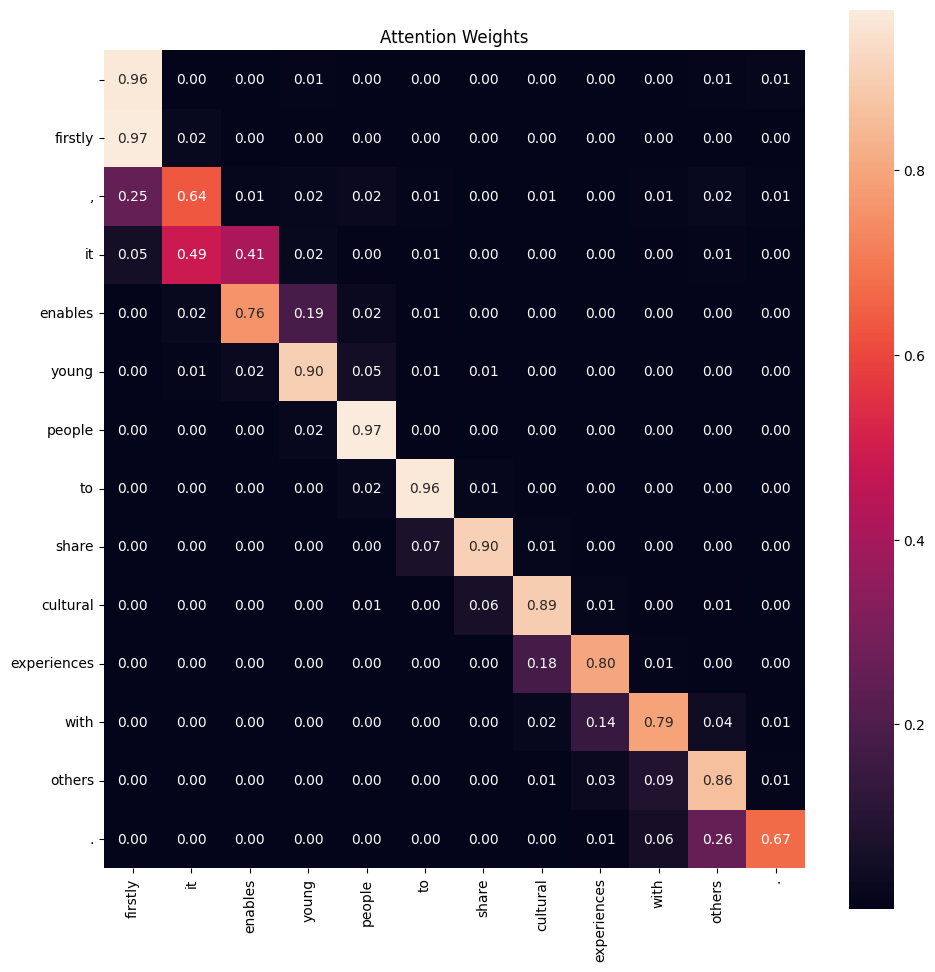

In [ ]:
weights = attention_weights.detach().cpu().numpy()

print(src_labels)
print(tgt_labels)

plot_attention_weights(weights, src_labels, tgt_labels)

In the plot above, the x axis represents the tokens/words of the input sequence (i.e., the German sentence), and the y axis represents the tokens/words of the target sequence (i.e., the German sentence). A high attention weight means that the prediction of the specific token/word in the target sequence was mostly influenced by that specific token/word in the input sequence.

---

## Discussion

This notebook went through all the basic steps required to build an RNN-based machine translation model. Apart from using only a small dataset for training, we also we skipped any proper evaluation of our model, which is a very non-trivial task in itself. Machine translation models are evaluated by comparing their generated translations with reference translations, typically done on a separate set of data called the evaluation or test set. The evaluation process measures the quality of the translations and assesses how well the model performs in terms of accuracy, fluency, and overall translation adequacy. Common metrics used for evaluating machine translation models include:

* **BLEU (Bilingual Evaluation Understudy):** BLEU is a widely used metric for machine translation evaluation. It measures the overlap between the model's generated translations and the reference translations based on n-grams (contiguous sequences of words). BLEU computes a precision score by comparing n-gram matches and penalizes overly long translations. Higher BLEU scores indicate better translation quality.

* **METEOR (Metric for Evaluation of Translation with Explicit ORdering):** METEOR is another popular metric that considers both precision and recall by matching unigrams (individual words) between the generated and reference translations. It also incorporates additional features such as stemming, synonym matching, and word order information. METEOR provides a score that correlates with human judgment of translation quality.

* **TER (Translation Edit Rate):** TER calculates the minimum number of edit operations (such as insertions, deletions, substitutions, and shifts) required to transform the generated translation into the reference translation. Lower TER scores indicate better translation quality.

* **ROUGE (Recall-Oriented Understudy for Gisting Evaluation):** ROUGE is primarily used for evaluating text summarization tasks, but it can also be adapted for machine translation evaluation. It measures the overlap of n-grams and word sequences between the generated and reference translations. ROUGE scores are commonly used in research papers to compare machine translation models.

* **NIST (NIST BLEU):** NIST is an extension of the BLEU metric that incorporates features like document-level statistics and different n-gram weighting schemes. It aims to align the metric with human evaluation and correlation.

* **Human Evaluation:* While automatic metrics provide a quick and objective assessment, human evaluation is crucial to gauge translation quality accurately. Human evaluators assess the translations based on fluency, adequacy, grammaticality, and overall meaning. They can also provide insights into other aspects of translation, such as domain-specific accuracy or stylistic appropriateness.

It's important to note that automatic metrics like BLEU, METEOR, TER, and ROUGE have limitations and may not perfectly align with human judgments. They are used as rough indicators and for comparing different models or approaches. Human evaluation remains an essential component to capture the nuances and quality aspects that automatic metrics may not fully capture.

---

## Summary

Machine translation can be effectively addressed using recurrent neural networks (RNNs) in natural language processing (NLP). RNNs are a class of neural networks designed to handle sequential data, making them well-suited for tasks like language translation. The key idea is to use an encoder-decoder architecture, where the input sentence is encoded into a fixed-length representation and then decoded into the target language. In this setup, the RNN encoder processes the source sentence word by word, capturing the contextual information and producing a meaningful representation known as the context vector. The context vector contains a condensed representation of the input sentence's semantic and syntactic information.

The RNN decoder takes the context vector as its initial input and generates the output translation one word at a time. At each time step, the decoder RNN uses the previously generated word and its own internal state to predict the next word in the target language. The process continues until the decoder generates an end-of-sentence token or reaches a predefined length. During training, the model is optimized to minimize the discrepancy between the generated translations and the reference translations. This is done by using techniques like teacher forcing, where the model is fed with the true output tokens during training to guide its learning.

The power of RNNs lies in their ability to capture the sequential dependencies and handle variable-length input and output sequences. The recurrent connections within the RNN enable the model to retain and utilize information from previous time steps. This makes RNN-based machine translation models capable of handling both short and long sentences while preserving the syntactic and semantic coherence in the translations. Overall, using recurrent neural networks for machine translation in NLP provides a flexible and effective framework to handle the complexities of language translation, allowing for improved translation quality and better preservation of the meaning and structure across different languages.